In [5]:
import kagglehub
import os
import shutil

dest = "./data/house-rooms-streets-image-dataset"
os.makedirs(dest, exist_ok=True)

# Descargar a la caché de kagglehub (path=dest en versiones viejas no es carpeta destino)
path = kagglehub.dataset_download("mikhailma/house-rooms-streets-image-dataset")

# Copiar todo a tu carpeta ./data/...
for name in os.listdir(path):
    src = os.path.join(path, name)
    dst = os.path.join(dest, name)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

path = dest
print("Path to dataset files:", path)

Path to dataset files: ./data/house-rooms-streets-image-dataset


In [9]:
# --- CLASIFICADOR (mínimo, todo en este notebook) ---
import numpy as np
import os

DATA_DIR = "./data/house-rooms-streets-image-dataset/kaggle_room_street_data/street_data"
CATEGORIES = ['apartment', 'church', 'garage', 'house', 'industrial', 'office_building', 'retail', 'roof', 'officebuilding']

# Lista de (ruta, etiqueta) desde nombres de archivo
paths, labels = [], []
for f in os.listdir(DATA_DIR):
    if not f.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    for cat in CATEGORIES:
        if cat in f.lower():
            paths.append(os.path.join(DATA_DIR, f))
            labels.append(cat)
            break

# Índice de clase
class_to_idx = {c: i for i, c in enumerate(CATEGORIES)}
y = np.array([class_to_idx[l] for l in labels])
print("Imágenes:", len(paths), "| Clases:", CATEGORIES)

Imágenes: 19354 | Clases: ['apartment', 'church', 'garage', 'house', 'industrial', 'office_building', 'retail', 'roof', 'officebuilding']


In [10]:
# Preprocesamiento mínimo: resize 224x224 + normalizar [0,1] (solo TensorFlow, sin PIL)
import tensorflow as tf

IMG_SIZE = 224
def load_and_preprocess(paths, labels, max_samples=None):
    n = min(len(paths), max_samples) if max_samples else len(paths)
    X = np.zeros((n, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    y = np.zeros(n, dtype=np.int32)
    for i in range(n):
        raw = tf.io.read_file(paths[i])
        img = tf.image.decode_image(raw, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        X[i] = img.numpy() / 255.0
        y[i] = labels[i]
    return X, y

# Usar subset para que sea rápido (quita max_samples para entrenar con todo)
X, y = load_and_preprocess(paths, y, max_samples=2000)
# Split 80% train / 20% validación (para validar bien la red)
n = len(X)
idx = np.random.permutation(n)
n_val = int(0.2 * n)
X_val, y_val = X[idx[:n_val]], y[idx[:n_val]]
X_train, y_train = X[idx[n_val:]], y[idx[n_val:]]
print("Train:", X_train.shape[0], "| Val:", X_val.shape[0])

Train: 1600 | Val: 400


In [11]:
# Modelo: ResNet50 (transfer learning) + una capa Dense
import tensorflow as tf

base = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False
model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(CATEGORIES), activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# Entrenar 1 época (rápido); validación con el 20% reservado
model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), batch_size=32)

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 636ms/step - accuracy: 0.1177 - loss: 2.1623 - val_accuracy: 0.1300 - val_loss: 2.0700


In [13]:
# Validación 1: métricas en el conjunto de validación (la red está ok si accuracy > ~0.1 y loss baja)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print("Validación — Loss: {:.4f} | Accuracy: {:.2%}".format(val_loss, val_acc))

Validación — Loss: 2.0700 | Accuracy: 13.00%


Matplotlib is building the font cache; this may take a moment.


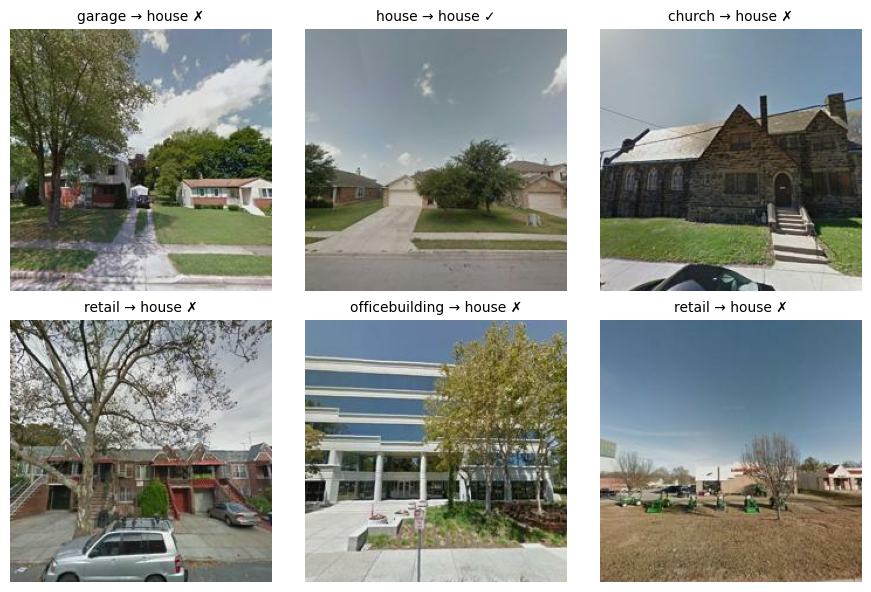

In [15]:
# Validación 2: revisar predicciones (true vs predicho) en unas cuantas imágenes
import matplotlib.pyplot as plt
preds = np.argmax(model.predict(X_val, verbose=0), axis=1)
n_show = 6
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_val[i])
    ax.axis("off")
    true = CATEGORIES[y_val[i]]
    pred = CATEGORIES[preds[i]]
    ok = "✓" if true == pred else "✗"
    ax.set_title("{} → {} {}".format(true, pred, ok), fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
# Salida: probabilidades por clase + categoría predicha (ejemplo con una imagen de validación)
idx = 0
prob = model.predict(X_val[idx:idx+1], verbose=0)[0]
pred = CATEGORIES[np.argmax(prob)]
print("Probabilidades por clase:", dict(zip(CATEGORIES, np.round(prob, 3))))
print("Categoría predicha:", pred)

Probabilidades por clase: {'apartment': np.float32(0.117), 'church': np.float32(0.146), 'garage': np.float32(0.13), 'house': np.float32(0.132), 'industrial': np.float32(0.072), 'office_building': np.float32(0.001), 'retail': np.float32(0.158), 'roof': np.float32(0.147), 'officebuilding': np.float32(0.096)}
Categoría predicha: retail
